In [1]:
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 33.0 MB/s eta 0:00:00


In [2]:
# Import các thư viện cần thiết
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import numpy as np
import re
import underthesea # Thư viện tách từ

from sklearn.model_selection import train_test_split # Thư viện chia tách dữ liệu

from transformers import AutoModel, AutoTokenizer # Thư viện BERT

# Thư viện train SVM
from sklearn.svm import SVC
from joblib import dump

Định nghĩa hàm

In [3]:

# Hàm load model phoBERT
def load_phoBert():
    v_phobert = AutoModel.from_pretrained("vinai/phobert-base")
    v_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
    return v_phobert, v_tokenizer

In [4]:

# Hàm chuẩn hoá câu
def standardize_data(row):
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    row = re.sub(r"[\.,\?]+$-", "", row)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm thang, ... trong câu
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
    row = row.strip().lower()
    return row

In [5]:
# Hàm load danh sách các từ vô nghĩa: lắm, ạ, à, bị, vì..
def load_stopwords():
    sw = []
    with open("/content/vietnamese-stopwords.txt", encoding='utf-8') as f:
        lines = f.readlines()
    for line in lines:
        sw.append(line.replace("\n",""))
    return sw


In [6]:
# Hàm load dữ liệu từ file data_1.csv để train model
def load_data():
    v_text = []
    v_label = []

    with open('/content/data_3.csv', encoding='utf-8') as f:
        lines = f.readlines()

    for line in lines:
        line = line.replace("\n","")
        print(line[:-2])
        v_text.append(standardize_data(line[:-2]))
        v_label.append(int(line[-1:].replace("\n", "")))

    print(v_label)
    return v_text, v_label

In [13]:
def make_phoBert_features(v_text):
    global phobert, tokenizer
    phobert, tokenizer = load_phoBert()
    v_tokenized = []
    sw = load_stopwords()
    max_len = 100 # Mỗi câu dài tối đa 100 từ
    for i_text in v_text:
        print("Đang xử lý line = ", i_text)
        # Phân thành từng từ
        line = underthesea.word_tokenize(i_text)
        # Lọc các từ vô nghĩa
        filtered_sentence = [w for w in line if not w in sw]
        # Ghép lại thành câu như cũ sau khi lọc
        line = " ".join(filtered_sentence)
        line = underthesea.word_tokenize(line, format="text")
        # Tokenize bởi phoBERT
        line = tokenizer.encode(line, max_length=max_len, pad_to_max_length=True, truncation=True)
        v_tokenized.append(line)

    # Chuyển đổi danh sách v_tokenized thành mảng NumPy
    padded_array = np.array(v_tokenized)
    print('padded:', padded_array[0])
    print('len padded:', padded_array.shape)

    # Chuyển mảng NumPy thành tensor
    padded_tensor = torch.tensor(padded_array).to(torch.long)
    print("Padded tensor shape:", padded_tensor.size())

    # Lấy features đầu ra từ phoBERT
    with torch.no_grad():
        last_hidden_states = phobert(input_ids=padded_tensor)

    # Trích xuất features từ output của phoBERT
    v_features = last_hidden_states[0][:, 0, :].numpy()
    print("Features shape:", v_features.shape)

    return v_features

In [18]:
def predict_text(text):
    # Chuẩn hoá và tiền xử lý đoạn văn bản
    processed_text = standardize_data(text)

    # Tạo đặc trưng từ đoạn văn bản mới bằng BERT
    new_features = make_phoBert_features([processed_text])

    # Sử dụng mô hình SVM để dự đoán
    prediction = cl.predict(new_features)

    return prediction[0]  # Trả về nhãn dự đoán


Phân tích dữ liệu


train


In [78]:
print("Chuẩn bị nạp danh sách các từ vô nghĩa (stopwords)...")
sw = load_stopwords()
print("Đã nạp xong danh sách các từ vô nghĩa")

print("Chuẩn bị nạp model BERT....")
phobert, tokenizer = load_phoBert()
print("Đã nạp xong model BERT.")

print("Chuẩn bị load dữ liệu....")
text, label = load_data()
print("Đã load dữ liệu xong")

print("Chuẩn bị tạo features từ BERT.....")
features = make_phoBert_features(text)
print("Đã tạo xong features từ BERT")

# Phân chia dữ liệu train, test 8-2, 7-3 PhpBert, LSTM
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=0)

#
# parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 2, 4], 'gamma': [0.125, 0.25, 0.5, 1, 2, 4]}
# from sklearn.model_selection import GridSearchCV
# clf = GridSearchCV(SVC(), param_grid=parameters)
# grid_search = clf.fit(X_train, y_train)
#
# print("Best score: %0.3f" % grid_search.best_score_)
# print(grid_search.best_estimator_)
#
# # best prarams
# print('best prarams:', clf.best_params_)

print("Chuẩn bị train model SVM....")
cl = SVC(kernel='rbf', probability=True, gamma=0.125)
cl.fit(features, label)
0
sc = cl.score(X_test, y_test)
print('Kết quả train model, độ chính xác = ', sc*100, '%')

# Save model
dump(cl, 'save_model.pkl')
print("Đã lưu model SVM vào file save_model.pkl")

Chuẩn bị nạp danh sách các từ vô nghĩa (stopwords)...
Đã nạp xong danh sách các từ vô nghĩa
Chuẩn bị nạp model BERT....
Đã nạp xong model BERT.
Chuẩn bị load dữ liệu....
﻿miên con chúng mày xe máy còn không có mà đi chứ à
miền nào cũng văn minh trừ parky thì không
parky là gì vậy các bác
parky gào thét kàa
câu lói cửa miệng của parky
câu nói cửa miệng của nemkiki
mày đi đâu nghe miền nam nói câu đó
vãi cặc
gặp namky là nó kiện rồi
mất hết lòng tốt ông ơi
văn hoá parky
lubu quá parky ơi
parky lải nhải
độc lạ parky
parky ngàn năm văn hiến chửi rất chi văn minh
parky nói tục
parky khóc
văn hoá parky
chuẩn parky rồi
người khát nước trong môi trường tự nhiên của họ parky parky
thô nhưng thật ai có xe rồi hiểu
npcparky
parky chửi nghệ ngọt thế kàa
parky cay cú
parky cay đỏ
parky cho mượn xe và cái kết
parky chửi gào thét trong cay cú
parky chửi quá chửi
độc lạ parky
bày chửi cali hay nhỉ
parky p phóng khoáng anh an nhàn rồi rực rỡ không khôn ngoan y yêu thương
parky khóc
parky khóc thét
em n

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 toàn cali comenhắn tin parky vậy nghĩ mà buồn
Đang xử lý line =  triệu hồi parky
Đang xử lý line =  parky vui thế
Đang xử lý line =  parky đấy
Đang xử lý line =  parky vãi chưởng
Đang xử lý line =  parky hết cứu
Đang xử lý line =  có đôi giép cũng không tha
Đang xử lý line =  đậm chất parky
Đang xử lý line =  cali đi trộm dép lun
Đang xử lý line =  namkiki trôm cả dép hảo hán
Đang xử lý line =  namkiki đi đâu phá đấy
Đang xử lý line =  đúng là cali
Đang xử lý line =  thấy tội parky bị namky trộm dép
Đang xử lý line =  biển 51 kìa mấy thằng cali
Đang xử lý line =  nhỏ tới lớn chơi với bạn chưa bao giờ chơi với parky
Đang xử lý line =  kid parky
Đang xử lý line =  parky con chứ trong nam giá trị 5tr nó chả thèm
Đang xử lý line =  parky rõ ràng đừng chối nhé
Đang xử lý line =  cali parky là gì vậy
Đang xử lý line =  thôi của đi thay người
Đang xử lý line =  cali là gì vậy mọi người
Đang xử lý line =  nói parky cái giận nữa nè nghe
Đang xử lý line =  parky là gì ạ
Đang xử lý line =  giọng

Predict

In [79]:
from joblib import load

# Load model từ file
cl = load('save_model.pkl')

In [80]:
# Đoạn text cần dự đoán
text_to_predict = "chòi má thằng nguuu"

# Dự đoán nhãn của đoạn text
predicted_label = predict_text(text_to_predict)
print("Nhãn dự đoán cho đoạn text là:", predicted_label)


Đang xử lý line =  chòi má thằng nguuu
padded: [    0 11823  5001  4028  6588  1881  1656     2     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1]
len padded: (1, 100)
Padded tensor shape: torch.Size([1, 100])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Features shape: (1, 768)
Nhãn dự đoán cho đoạn text là: 1


Đánh giá mô hình

In [81]:
from sklearn.metrics import confusion_matrix, classification_report

# Dự đoán nhãn trên tập test
y_pred = cl.predict(X_test)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# In ma trận nhầm lẫn và báo cáo hiệu suất
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[169  15   1]
 [ 10 201   0]
 [ 12  14  83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       185
           1       0.87      0.95      0.91       211
           2       0.99      0.76      0.86       109

    accuracy                           0.90       505
   macro avg       0.92      0.88      0.89       505
weighted avg       0.90      0.90      0.90       505



In [82]:
from sklearn.metrics import accuracy_score

# Dự đoán nhãn của dữ liệu test
y_pred = cl.predict(X_test)

# Tính toán độ chính xác
accuracy = accuracy_score(y_test, y_pred)

# In kết quả
print('Độ chính xác của mô hình:', accuracy)


Độ chính xác của mô hình: 0.897029702970297


In [83]:
from sklearn.metrics import f1_score

# Dự đoán nhãn của dữ liệu test
y_pred = cl.predict(X_test)

# Tính toán F1-score
f1 = f1_score(y_test, y_pred, average='weighted')  # hoặc average='macro'

# In kết quả
print('F1-score của mô hình:', f1)


F1-score của mô hình: 0.8958309363971704


In [84]:
from sklearn.metrics import precision_score, recall_score

# Dự đoán nhãn của dữ liệu test
y_pred = cl.predict(X_test)

# Tính toán Precision và Recall
precision = precision_score(y_test, y_pred, average='weighted')  # hoặc average='macro'
recall = recall_score(y_test, y_pred, average='weighted')  # hoặc average='macro'

# In kết quả
print('Precision của mô hình:', precision)
print('Recall của mô hình:', recall)


Precision của mô hình: 0.9025527378271956
Recall của mô hình: 0.897029702970297


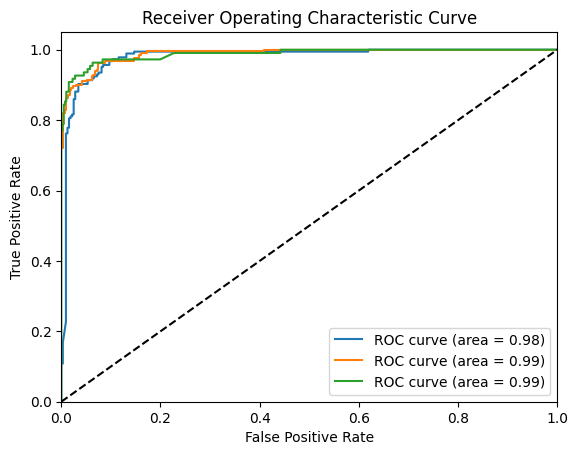

ROC AUC cho nhãn 0 : 0.9795270270270271
ROC AUC cho nhãn 1 : 0.987813134732566
ROC AUC cho nhãn 2 : 0.987698081734779


In [85]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Chuyển đổi các nhãn thành các vector one-hot
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Dự đoán xác suất của dữ liệu test
y_pred_prob = cl.predict_proba(X_test)

# Tính toán đường cong ROC và AUC cho mỗi nhãn
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Với 3 nhãn 0, 1, 2
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Vẽ đường cong ROC cho mỗi nhãn
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# In diện tích dưới đường cong ROC (AUC) cho mỗi nhãn
for i in range(3):
    print('ROC AUC cho nhãn', i, ':', roc_auc[i])


visualize data


In [86]:
import pandas as pd

# Đọc dữ liệu từ file CSV (hoặc bất kỳ định dạng nào phù hợp)
data = pd.read_csv('/content/data_3.csv', header=None, names=['comment', 'label'])

# Thống kê theo nhãn (label)
label_counts = data['label'].value_counts()

# In ra số lượng mẫu cho mỗi nhãn
print("Thống kê theo nhãn (label):")
print(label_counts)


Thống kê theo nhãn (label):
1    1053
0     912
2     559
Name: label, dtype: int64


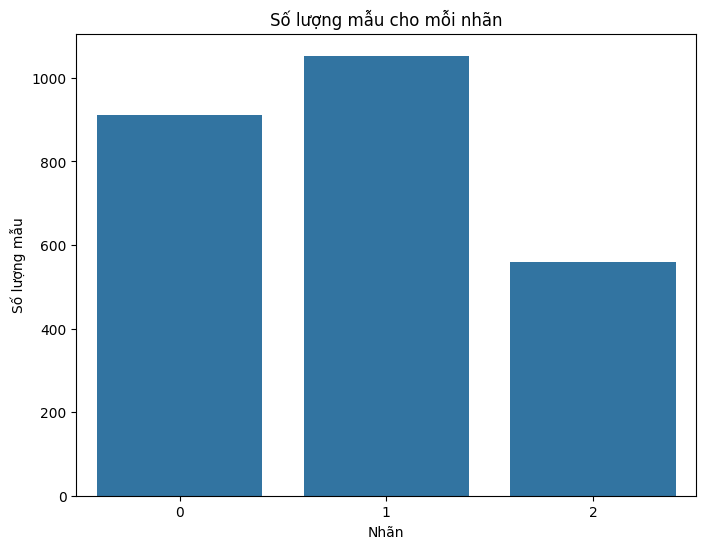

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/data_3.csv', header=None, names=['text', 'label'])
# Biểu đồ cột (Bar chart)
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data)
plt.title('Số lượng mẫu cho mỗi nhãn')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng mẫu')
plt.show()

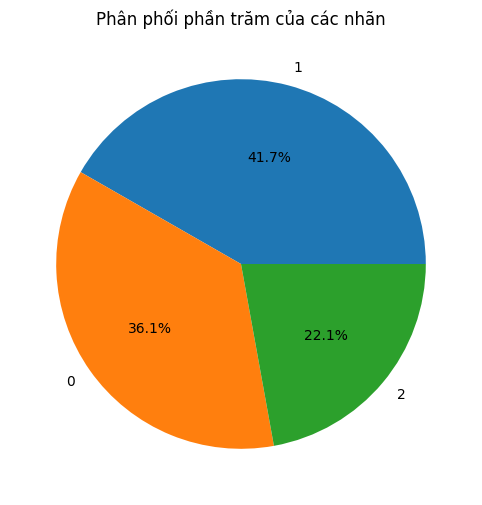

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/data_3.csv', header=None, names=['text', 'label'])
# Biểu đồ tròn (Pie chart)
plt.figure(figsize=(8, 6))
data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Phân phối phần trăm của các nhãn')
plt.ylabel('')
plt.show()

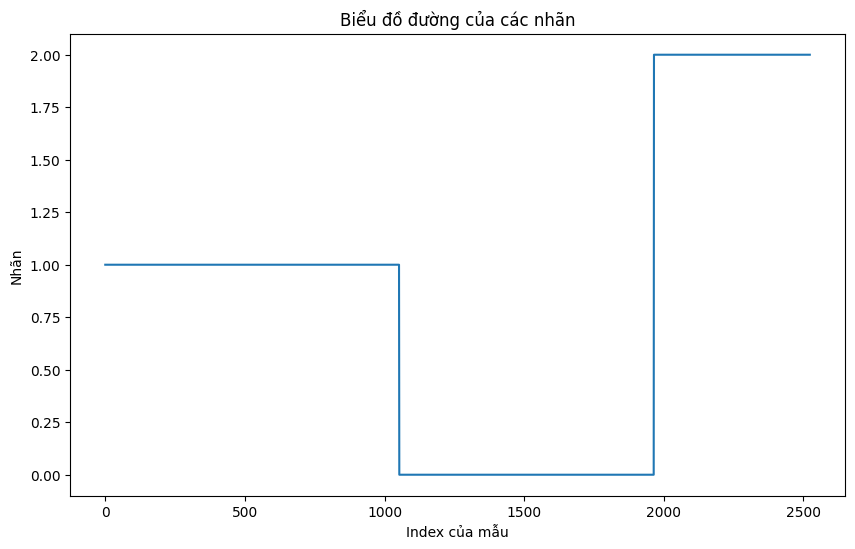

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/data_3.csv', header=None, names=['text', 'label'])

# Biểu đồ đường (Line chart)
plt.figure(figsize=(10, 6))
sns.lineplot(x=data.index, y=data['label'])
plt.title('Biểu đồ đường của các nhãn')
plt.xlabel('Index của mẫu')
plt.ylabel('Nhãn')
plt.show()
